In [137]:
#
# This is an example from jbr Reactor Design Book
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm_red.m
#

Reduced order model with states $V, \epsilon_2$:
$$\frac{dV}{dt} = Q^{in}_B(t)$$
$$\frac{d\epsilon_2}{dt} = \frac{Q^{in}_B(t)c_{Bf}(n^{added}_B-2\epsilon_2)}{(n^{added}_B-2\epsilon_2) + k(n_{A0} - n^{added}_B + \epsilon_2)} $$ 

Calculation of $n_B^{added}$:
$$ n_B^{added} = (V - V(0))c_{Bf} $$

Parameters:
$k = 2.48, \;\;n_{A0} = 2.35$

Initial conditions:
$V = 2370, \;\;\epsilon_2 = 0$

When I just used $V, \epsilon_2$ as state variables, kipet had trouble even simulating the system. So I rewrote the system with auxiliary algebraic variables which simulated without a problem.

$$\frac{dV}{dt} = Q^{in}_B(t)$$
$$\frac{d\epsilon_2}{dt} = y_1(t) $$ 
$$ y_1(t)[(n^{added}_B-2\epsilon_2) + k(n_{A0} - n^{added}_B + \epsilon_2)] = Q^{in}_B(t)c_{Bf}(n^{added}_B-2\epsilon_2) $$
$$ n_B^{added} = (V - V(0))c_{Bf} $$

While this simulated without issues, I am having trouble doing parameter estimation of $k$ and $n_{A0}$

In [138]:
from kipet import KipetModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t

In [139]:
# Import data set with flow of B over time
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/flow.dat'
flow_df = pd.read_csv(filename, delimiter=r"\s+", header = None)
flow_df.columns = ['time', 'Qf', 'x']
flow_df['qin_B'] = flow_df['Qf'] / 0.728
flow_df = flow_df.set_index('time')
qinB_traj = flow_df[['qin_B']]
qinB_traj

,qin_B
time,
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319
49.0,1.669967
...,...
829.0,0.000990
839.0,0.000782
849.0,0.000643


In [140]:
# insert first row for time 0
qinB_row0 = pd.DataFrame({'time':[0], 'qin_B':[0]}).set_index('time')
qinB_traj = qinB_traj.append(qinB_row0).sort_index()
qinB_traj.head()

,qin_B
time,
0.0,0.000000
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319


In [141]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/lc.dat'
lc_data = pd.read_csv(filename, delimiter=r"\s+", header = None)
lc_data.columns = ['time', 'y']
lc_data = lc_data.set_index('time')

In [142]:
lc_data.head()

,y
time,
414,0.1705
424,0.1604
434,0.1325
444,0.1084
493,0.1014


In [143]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('V', state = 'state', init = 2370)
r1.add_component('eps2', state = 'concentration', init = 0.0)
#r1.add_component('qin_B', state = 'trajectory')

r1.add_algebraic_variables('qin_B')
r1.add_algebraic_variables('nBadded')
r1.add_algebraic_variables('y1')
r1.add_algebraic_variables('y', init = 0.2, bounds = (0.0, 1.0))

r1.add_parameter('k', init = 2.48, bounds = (0, 10))
r1.add_parameter('na0', init = 2.34, bounds = (0, 10))

cbf = 0.00721
V0 = 2370

In [144]:
def rule_odes(m,t):
        
    exprs = dict()
    exprs['V'] = m.Y[t,'qin_B']
    exprs['eps2'] = m.Y[t, 'y1']
    return exprs

r1.add_equations(rule_odes) 

In [145]:
def rule_algebraics(m, t):
    r = list()
    r.append(m.Y[t,'nBadded'] - (m.X[t, 'V'] - V0) * cbf)
    r.append(m.Y[t,'y1'] * ((m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']) + m.P['k']*(m.P['na0'] - m.Y[t,'nBadded'] + m.Z[t, 'eps2'])) - m.Y[t,'qin_B'] * cbf * (m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']))
    r.append(m.Y[t, 'y'] * m.Y[t, 'nBadded'] - (m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']))
    return r

r1.add_algebraics(rule_algebraics)

In [146]:
r1.add_objective_from_algebraic('y')

In [147]:
r1.add_dataset('lc_data', category = 'custom', data = lc_data)
r1.add_dataset('Traj', category = 'trajectory', data = qinB_traj)

In [148]:
r1.fix_from_trajectory('Y', 'qin_B', 'Traj')
r1.set_times(0, 900)

In [149]:
r1.settings.collocation.nfe = 60
r1.settings.collocation.ncp = 3
r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
r1.settings.solver.linear_solver = 'ma27'

In [150]:
r1.run_opt()

times are: <class 'tuple'>
0 900
 If this is the desired behavior, some algebraics must be added after the model is created.
No variance information for V found, setting equal to unity
No variance information for eps2 found, setting equal to unity
Ipopt 3.12: nlp_scaling_method=user-scaling
linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     4152
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1303

Total number of variables....................

  89r 2.5409298e-01 5.76e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.11e-07R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 2.5387029e-01 3.04e-04 2.78e+03  -1.0 1.97e-01    -  9.79e-01 9.39e-02f  2
  91  2.5389182e-01 3.04e-04 1.10e+04  -1.0 1.23e+02    -  9.81e-01 9.30e-04f  2
  92  2.5396425e-01 2.88e-04 2.62e+04  -1.0 4.32e+00    -  3.09e-01 5.45e-02h  1
  93  2.5396576e-01 2.87e-04 6.20e+04  -1.0 7.13e+00    -  1.50e-02 1.00e-03h  1
  94  2.5392611e-01 2.87e-04 1.47e+05  -1.0 1.25e+02    -  1.61e-03 1.83e-03f  2
  95  2.5392610e-01 2.87e-04 2.59e+05  -1.0 4.15e+00   4.8 5.21e-03 1.50e-05h  1
  96  2.5392643e-01 2.87e-04 6.55e+07  -1.0 9.70e+00   4.3 2.48e-02 9.09e-05h  1
  97  2.5394342e-01 2.86e-04 5.58e+07  -1.0 1.51e+01    -  1.38e-01 3.41e-03f  2
  98  2.5390698e-01 2.83e-04 5.62e+07  -1.0 8.41e+01    -  3.20e-02 9.72e-03h  1
  99  2.5396667e-01 2.63e-04 5.82e+07  -1.0 1.34e+01    -  2.05e-02 7.04e-02f  2
iter    objective    inf_pr 

 235  2.5382639e-01 5.12e-13 7.70e+06  -8.6 1.51e-07  13.7 5.71e-01 1.00e+00h  1
 236  2.5382639e-01 5.23e-13 3.77e+06  -8.6 8.26e-09  13.2 1.00e+00 5.00e-01h  2
 237  2.5382639e-01 5.12e-13 2.83e+06  -8.6 4.18e-09  12.7 1.00e+00 2.50e-01h  3
 238  2.5382639e-01 5.23e-13 1.41e+06  -8.6 3.14e-09  12.3 1.00e+00 5.00e-01h  2
 239  2.5382639e-01 5.23e-13 1.41e+06  -8.6 1.58e-09  11.8 1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  2.5382639e-01 5.23e-13 1.41e+06  -8.6 1.57e-09  11.3 1.00e+00 3.05e-05h 16
 241  2.5382639e-01 6.27e-13 2.10e+04  -8.6 1.57e-09  10.8 1.00e+00 1.00e+00s 22
 242  2.5382639e-01 7.56e-13 1.78e-01  -8.6 4.73e-12  10.4 1.00e+00 1.00e+00s 22

Number of Iterations....: 242

                                   (scaled)                 (unscaled)
Objective...............:   2.5382639297869775e-01    2.5382639297869775e-01
Dual infeasibility......:   1.7791945870689152e-01    1.7791945870689152e-01
Constraint vio


RESULTS
Z:
                     eps2
0.000000   -6.801880e-68
2.005973    7.583558e-04
8.344027    7.373795e-04
12.937500   1.481402e-02
14.943473   2.824728e-02
...                  ...
878.319184  2.243792e+00
884.000000  2.243805e+00
886.480816  2.243853e+00
894.319184  2.243684e+00
900.000000  2.243584e+00

[181 rows x 1 columns]

X:
                       V
0.000000    2370.000000
2.005973    2370.210362
8.344027    2370.204530
12.937500   2372.092317
14.943473   2373.955460
...                 ...
878.319184  2992.371522
884.000000  2992.374976
886.480816  2992.376485
894.319184  2992.381251
900.000000  2992.384705

[181 rows x 1 columns]

dZdt:
                 eps2
0.000000    0.000000
2.005973   -0.000034
8.344027    0.001041
12.937500   0.005620
14.943473   0.007990
...              ...
878.319184  0.000004
884.000000  0.000004
886.480816  0.000004
894.319184 -0.000031
900.000000  0.000004

[181 rows x 1 columns]

dXdt:
                    V
0.000000    0.000000
2.005973    

In [151]:
r1.results.show_parameters


The estimated parameters are:
k 5.438733212615566e-09
na0 2.385091851359696


Parameter estimator is not able to find the parameter estimate of $k$ which is closer to 2

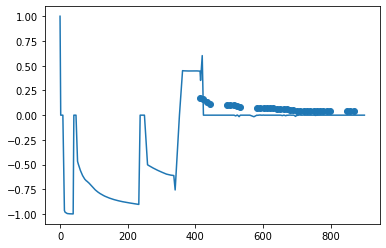

In [152]:
fig, ax = plt.subplots()
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(r1.results.Y.index, r1.results.Y['y'])

The value of $y$ is going below zero even though the bounds are [0, 1]

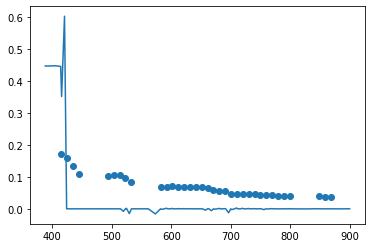

In [153]:
fig, ax = plt.subplots()
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(r1.results.Y.index[r1.results.Y.index >= 380], r1.results.Y['y'][r1.results.Y.index >= 380])

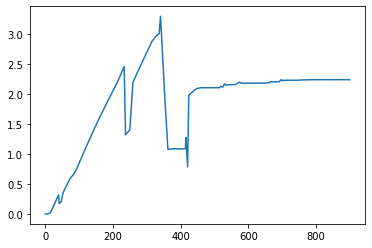

In [154]:
fig, ax = plt.subplots()
ax.plot(r1.results.Z.index, r1.results.Z['eps2'])

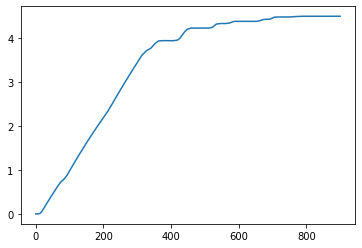

In [155]:
fig, ax = plt.subplots()
ax.plot(r1.results.Y.index, r1.results.Y['nBadded'])

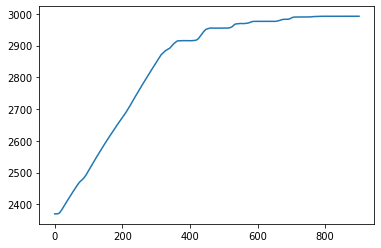

In [156]:
fig, ax = plt.subplots()
ax.plot(r1.results.X.index, r1.results.X['V'])

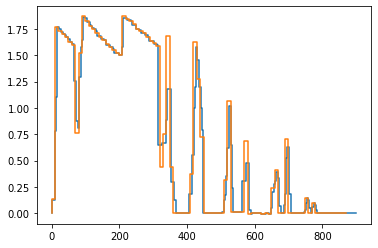

In [157]:
fig, ax = plt.subplots()
ax.step(r1.results.Y.index, r1.results.Y['qin_B'])
ax.step(qinB_traj.index, qinB_traj['qin_B'])